In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [95]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


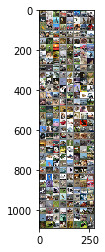

  car   dog  deer truck


In [4]:
import numpy as np
import matplotlib.pyplot as plt
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
import torch
import torch.nn as nn
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

In [6]:
import torch.optim as optim
net = VGG('VGG11').to(device)

In [7]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

In [8]:
def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 10))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for i,(images, target) in enumerate(dataloader):
            embeddings[k:k+len(images)] = model(images.to(device)).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Using triplet loss

In [9]:
from datasets import BalancedBatchSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from trainer import fit
# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(torch.tensor(np.asarray(trainset.targets)), n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(torch.tensor(np.asarray(testset.targets)), n_classes=10, n_samples=25)

In [10]:
cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(trainset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(testset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric,AccumulatedAccuracyMetric


margin = .6
embedding_net = VGG('VGG11')
model = embedding_net
if cuda:
    model.cuda()

loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))  
lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 150

In [11]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

F:\torchenv\lib\site-packages\torch\optim\lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/50000 (0%)]	Loss: 1.116414	Average nonzero triplets: 2999.0
Train: [37500/50000 (75%)]	Loss: 0.780230	Average nonzero triplets: 2999.933774834437
Epoch: 1/20. Train set: Average loss: 0.7535	Average nonzero triplets: 2999.9447236180904
Epoch: 1/20. Validation set: Average loss: 0.6483	Average nonzero triplets: 2999.923076923077
Train: [0/50000 (0%)]	Loss: 0.606642	Average nonzero triplets: 3000.0
Train: [37500/50000 (75%)]	Loss: 0.620605	Average nonzero triplets: 2999.8940397350993
Epoch: 2/20. Train set: Average loss: 0.6209	Average nonzero triplets: 2999.8442211055276
Epoch: 2/20. Validation set: Average loss: 0.6271	Average nonzero triplets: 2999.74358974359
Train: [0/50000 (0%)]	Loss: 0.613407	Average nonzero triplets: 3000.0
Train: [37500/50000 (75%)]	Loss: 0.600914	Average nonzero triplets: 2998.4900662251657
Epoch: 3/20. Train set: Average loss: 0.6030	Average nonzero triplets: 2998.035175879397
Epoch: 3/20. Validation set: Average loss: 0.6430	Average nonzero triplets

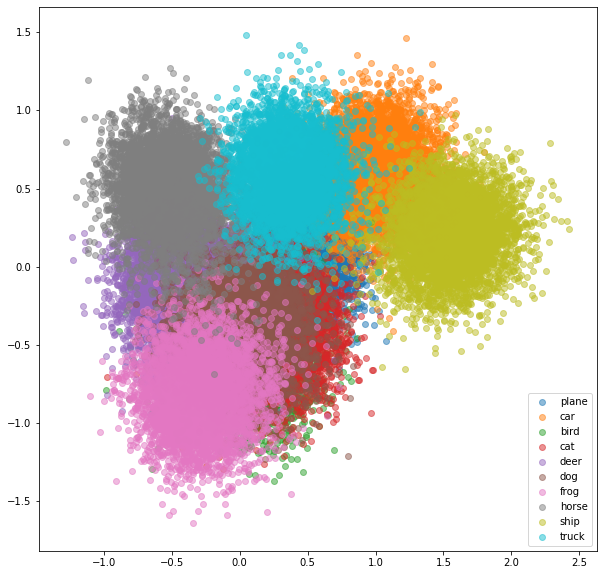

In [12]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(trainloader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)

In [19]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, 1, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric(),AccumulatedAccuracyMetric()])

Train: [0/50000 (0%)]	Loss: 0.398913	Average nonzero triplets: 1622.0	Accuracy: 10.0
Train: [37500/50000 (75%)]	Loss: 0.415689	Average nonzero triplets: 1650.4966887417218	Accuracy: 8.633112582781457
Epoch: 1/1. Train set: Average loss: 0.4141	Average nonzero triplets: 1656.6381909547738	Accuracy: 8.679396984924622
Epoch: 1/1. Validation set: Average loss: 0.9596	Average nonzero triplets: 2966.5384615384614	Accuracy: 9.364102564102565


In [18]:
from metrics import AccumulatedAccuracyMetric

In [26]:
train_embeddings_ocl

array([[-0.70086634,  0.39907253, -0.74885148, ...,  0.24416822,
        -1.72239971,  1.7094332 ],
       [ 1.87556422,  0.12831959,  0.33689299, ..., -0.48639953,
        -1.72545063, -0.04000053],
       [ 0.29480019, -0.49036962, -0.10413738, ...,  0.34553668,
        -1.23638356,  0.74871707],
       ...,
       [-0.73771739,  0.21745908, -1.15169489, ...,  0.31481192,
        -1.29930639,  1.03882766],
       [ 0.67433667,  0.82670122,  0.26151299, ..., -0.55501574,
        -1.42769992,  1.24476302],
       [-0.54257333, -0.43419555, -0.59346312, ...,  0.83296472,
        -1.90087318,  1.20285511]])

In [66]:
class Final(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Linear(10, 10)

    def forward(self, x):
        out = self.classifier(x)
        return out

In [67]:
train_embeddings_ocl, train_labels_ocl

(array([[-0.70086634,  0.39907253, -0.74885148, ...,  0.24416822,
         -1.72239971,  1.7094332 ],
        [ 1.87556422,  0.12831959,  0.33689299, ..., -0.48639953,
         -1.72545063, -0.04000053],
        [ 0.29480019, -0.49036962, -0.10413738, ...,  0.34553668,
         -1.23638356,  0.74871707],
        ...,
        [-0.73771739,  0.21745908, -1.15169489, ...,  0.31481192,
         -1.29930639,  1.03882766],
        [ 0.67433667,  0.82670122,  0.26151299, ..., -0.55501574,
         -1.42769992,  1.24476302],
        [-0.54257333, -0.43419555, -0.59346312, ...,  0.83296472,
         -1.90087318,  1.20285511]]),
 array([7., 8., 2., ..., 7., 9., 4.]))

In [75]:
from torch.utils import data
my_dataset = data.TensorDataset(torch.Tensor(train_embeddings_ocl),torch.Tensor(train_labels_ocl) )

In [69]:
trainloader = torch.utils.data.DataLoader(my_dataset, batch_size=256,
                                          shuffle=True, num_workers=0)

In [70]:
finLayer = Final().to(device)

In [71]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(finLayer.parameters(), lr=0.001, momentum=0.9)

In [94]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = finLayer(inputs.to(device))
        loss = criterion(outputs,labels.to(device,dtype=torch.long))#batch_hard_triplet_loss(labels=labels,embeddings=outputs,margin=0.3)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('%d, loss: %.3f' %
              (epoch + 1, running_loss / len(trainloader)))

print('Finished Training')

1, loss: 0.666
2, loss: 0.641
3, loss: 0.619
4, loss: 0.598
5, loss: 0.579
6, loss: 0.562
7, loss: 0.546
8, loss: 0.531
9, loss: 0.518
10, loss: 0.505
Finished Training


In [96]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = finLayer(model(images.to(device)))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [90]:
def extract_embeddings(dataloader, finLayer,model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 10))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for i,(images, target) in enumerate(dataloader):
            embeddings[k:k+len(images)] = model(images.to(device)).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

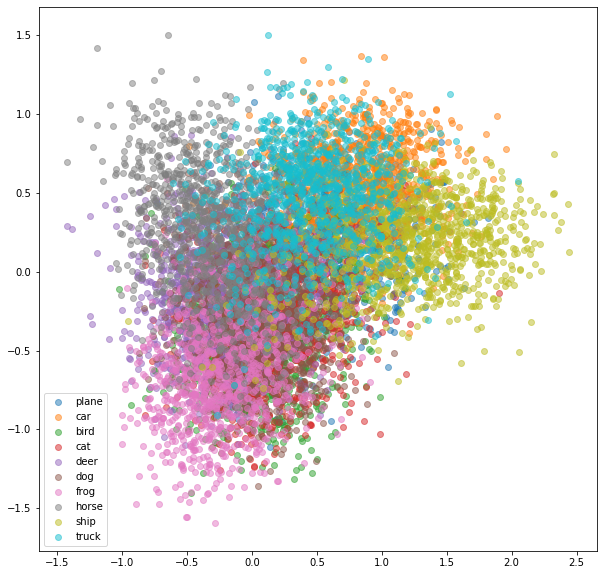

In [99]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(testloader, finLayer,model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)